# ex12 뉴스 요약봇 만들기  
  
## Objective  
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.  
분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.  
  
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.  
모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.  

3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.  
두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.  
  
https://wikidocs.net/72820 

## 데이터 수집하기  

In [18]:
from importlib.metadata import version
import nltk
nltk.download('stopwords')
import tensorflow as tf
import summa

import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 데이터 전처리하기 (추상적 요약)  
중복 제거  
결측치 제거  
문맥에 따른 중복문자 제거  
텍스트 정규화  
불용어 제거  
특수문자 제거  
다시한번 결측치 제거  
이상치 제거 (지나치게 긴 문장 등)  
  
이후 토크나이징을 실행한다고 학습했습니다  
학습한 순서에 맞추어 데이터를 로드, 전처리를 진행합니다  
  
### 데이터 로드 및 중복/결측치 제거

In [19]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [20]:
data.shape

(98401, 2)

In [21]:
data.sample(10)

,headlines,text
8614,ICC pitches for Women's T20Is at Birmingham Co...,The International Cricket Council has pitched ...
12799,Saina in Denmark Open final after winning semi...,Indian shuttler Saina Nehwal reached the final...
69286,18 of 43 McDonald's outlets reopened in Delhi:...,McDonald's estranged partner Vikram Bakshi on ...
33496,Kalpana Chawla's husband denies rights to make...,Kalpana Chawla's husband Jean-Pierre Harrison ...
25229,Ex-South Korean President sentenced to 8 more ...,Former South Korean President Park Geun-hye wa...
73656,"Man kills daughters, flees leaving suicide not...",A Bihar businessman reportedly shot dead his t...
10686,Thailand to waive visa-on-arrival fees for Ind...,Thailand's cabinet has approved a measure to t...
55789,US' new security strategy has imperial nature:...,Russian spokesperson Dmitry Peskov on Tuesday ...
77162,NASA jets to chase upcoming solar eclipse usin...,Two NASA jets would be chasing the moon's shad...
26409,BSNL becomes India's 1st network to launch 'in...,BSNL on Wednesday became the country's first t...


데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.  
추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있습니다.  
추출적 요약을 하는 경우에는 오직 text열만을 사용해야 합니다.  

In [22]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


전체 갯수 중 98400개 중, 41개의 text 중복이 있습니다  
headline이 중복이어도 내용이 다를 수 있으니, text 중복을 제거해주도록 하겠습니다

In [23]:
data.drop_duplicates(subset = ['text'], inplace=True)
data.shape

(98360, 2)

In [24]:
data.isna().sum()

headlines    0
text         0
dtype: int64

빈 데이터가 있다면 제거해줬어야 했을텐데, 다행히도 없었습니다 

### 텍스트 정규화, 불용어 제거  
apostrophe등을 사용하는 다양한 문장의 표현을 단일화합니다  
문맥에 크게 의미를 주지 않는 단어 (stopword)등을 제거합니다  
  
다만 개인적으로 우려되는 점은  
https://wikidocs.net/21693  
에 소개되어 있듯이, 고유명사등의 처리  
예를 들어, 위 sample의 2번째인 Elon Musk-led 이런 부분, 고유명사와 하이픈으로 이어지는 부분등은 어떻게 처리해야 할지 고민이 됩니다  
기존의 방식은 일괄 소문자화, 온점제거, 특수문자 제거를 해왔지만, 일괄적으로 수행할 시 문장의 의미를 잃어버리지 않을까 고심하게 되는 부분입니다  
nltk에서 여러 방식의 토크나이저를 제공하는데, News in english에 대한 것은 찾지 못하였습니다  
일단, 첫술에 완벽할 수는 없으므로, lms에 소개된 방향으로 진행 후 개선점을 탐색해보겠습니다  
(나중에 https://datascienceschool.net/03%20machine%20learning/03.01.01%20NLTK%20%EC%9E%90%EC%97%B0%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html  
랑 https://excelsior-cjh.tistory.com/67  
써볼수도 있을거 같습니다)  

일단 하자!!  

#### 정규화  
특수문자 제거 전에 정규화를 먼저 해야, 단어의 의미를 잃어버리는 불상사를 방지할 수 있다는 걸 지금 깨달았습니다  

In [25]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [26]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [27]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [28]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


테스트 결과, 함수가 올바로 작동했습니다  
데이터셋에 적용~

In [29]:
data.head(20)

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...
6,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...
8,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",Congress candidate Shafia Zubair won the Ramga...


In [31]:
clean_df = data.copy()    #원본은 유지
clean_df['headlines'] = clean_df['headlines'].apply(preprocess_sentence, args = (False))
clean_df['text'] = clean_df['text'].apply(preprocess_sentence)
clean_df.head(20)

,headlines,text
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...
5,rahat fateh ali khan denies getting notice smu...,pakistani singer rahat fateh ali khan denied r...
6,india get lowest odi total new zealand,india recorded lowest odi total new zealand ge...
7,govt directs alok verma join work day retirement,weeks ex cbi director alok verma told departme...
8,called pm modi sir times satisfy ego andhra cm,andhra pradesh cm chandrababu naidu said met u...
9,cong wins ramgarh bypoll rajasthan takes total...,congress candidate shafia zubair ramgarh assem...


전처리가 잘 되긴 했는데.. 대문자.. 고유명사.. 자꾸 신경이 쓰이는 건 어쩔수 없네요  
  
#### 결측치 확인  
데이터 처리과정에서 새로 결측치가 나왔을 수도 있으니, 확인해보고 제거합니다  

In [32]:
clean_df.replace('', np.nan, inplace = True)
clean_df.isna().sum()

headlines    0
text         0
dtype: int64

In [43]:
#clean_df.dropna(axis=0, inplace = True)

#### 이상치 제거  
데이터셋 내에서 특정 문장이 너무 길 경우, 데이터셋 전체로 학습할 수 있다는 장점은 있지만  
pad_sequence메서드를 사용할 때 학습에 사용된 문장의 최대 길이로 padding이 진행되어  
대부분의 문장이 문장 길이보다 0이 더 많은 학습을 진행하게 됩니다 (피드백 감사합니다!)  
추상적 분석의 결과물이 좋게 나오지 않게 우려되는 부분이므로, 일정 수치에서 너무 벗어나는 길이를 이상치로 규정하고 제거하도록 합니다  

In [51]:
headlines_len = [len(s.split()) for s in clean_df['headlines']]
text_len = [len(s.split()) for s in clean_df['text']]

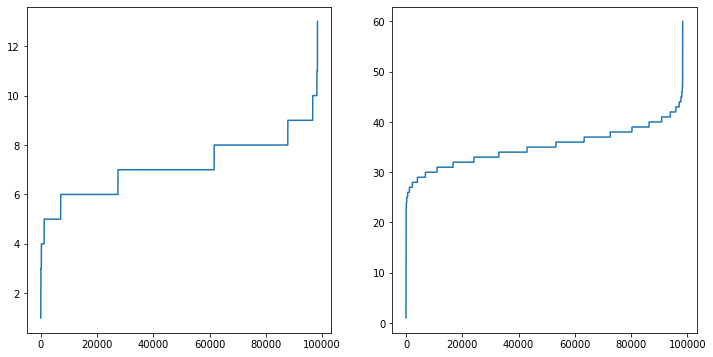

In [56]:
headlines_len.sort()
text_len.sort()

fig = plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(headlines_len)

plt.subplot(1, 2, 2)
plt.plot(text_len)

In [67]:
pd.DataFrame(headlines_len).describe()

,0
count,98360.000000
mean,7.136183
std,1.162421
min,1.000000
25%,6.000000
50%,7.000000
75%,8.000000
max,13.000000


In [68]:
pd.DataFrame(text_len).describe()

,0
count,98360.000000
mean,35.099685
std,3.799406
min,1.000000
25%,33.000000
50%,35.000000
75%,38.000000
max,60.000000


헤드라인은 min = 1 , mean = 7 , max = 13 입니다  
텍스트의 mean은 35이지만, 1개의 단어로만 되어있는 텍스트도 있고, mean의 1.5배가 넘는 텍스트도 있습니다  
  
전체 데이터수가 98360개, 그 중

In [75]:
print(headlines_len.count(1), "\t", headlines_len.count(2), "\t", headlines_len.count(3), "\t", headlines_len.count(4))

2 	 20 	 163 	 998


headline의 단어가 1개 2개 인 경우는 전체 데이터에서 매우 적은 숫자를 가지고 있으므로, 제거하겠습니다  
headline이 짧은 경우를 학습시키고 싶지 않아서 입니다

In [76]:
print(headlines_len.count(13), "\t", headlines_len.count(12), "\t", headlines_len.count(11), "\t", headlines_len.count(10))

2 	 23 	 188 	 1496


headline의 단어가 13개 12개 인 경우가 매우 적은 숫자를 가지므로, 제거하겠습니다  

In [80]:
text_len[int(9836/2)]  #짧은쪽 5%의 경계값

29

In [81]:
print(text_len.count(1), "\t", text_len.count(2), "\t", text_len.count(3), "\t", text_len.count(4))

1 	 0 	 0 	 0


텍스트는 단어가 한개인 경우가 단 하나, 나머지 결측치가 제대로 제거가 안되었던걸까요? lms에서는 문장 하나하나를 떼서 전처리를 수행했지만, 저는 apply함수를 사용하여 간략히 사용했습니다  
확인하도록 하겠습니다  

In [104]:
for s in clean_df['text']:
    if(len(s.split()) == 1):
        print(s)

text


In [105]:
print(clean_df.loc[clean_df['text'] == 'text'])

    headlines  text
52  headlines  text


In [107]:
clean_df.loc[52]

headlines    headlines
text              text
Name: 52, dtype: object

52행에 뭔가 웃기는 값이 들어가있네요 하 ㅎ ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 어쩐지 전처리하는데 왜!!! ㅋㅋㅋㅋ     
드롭해줍니다  

In [108]:
clean_df.drop(52, inplace=True)

내용 길이분석을 위해, text_len list에서 1을 빼고 데이터를 다시 파악해보겠습니다

In [109]:
text_len.remove(1)
pd.DataFrame(text_len).describe()

,0
count,98359.000000
mean,35.100032
std,3.797869
min,18.000000
25%,33.000000
50%,35.000000
75%,38.000000
max,60.000000


제일 짧은 내용은 18단어 였습니다  
짧은 내용은 아무튼! 남겨주기로 하고 내용이 긴 경우를 보겠습니다

In [115]:
text_len[-98]

47

10% 상위로 제일 긴 값 9830개는 단어가 41개, 5%는 42개, 등등이었습니다  
98개는 데이터의 0.1%, 47개입니다  

In [119]:
print(text_len.count(50), "\t", text_len.count(51), "\t", text_len.count(52), "\t", text_len.count(53))

14 	 4 	 4 	 3


50개가 넘어가는 경우는 정말 희박하군요!!  
길이를 정하고 정제하겠습니다  
정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제하겠습니다

In [123]:
headlines_min_len = 2    #2개 이하는 제거
headlines_max_len = 12
text_max_len = 50

clean_df = clean_df[clean_df['text'].apply(lambda x: len(x.split()) <= text_max_len)]
clean_df = clean_df[clean_df['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
clean_df = clean_df[clean_df['headlines'].apply(lambda x: len(x.split()) > headlines_min_len)]

clean_df.shape

(98322, 2)

98360개 중 38개가 제거되었습니다

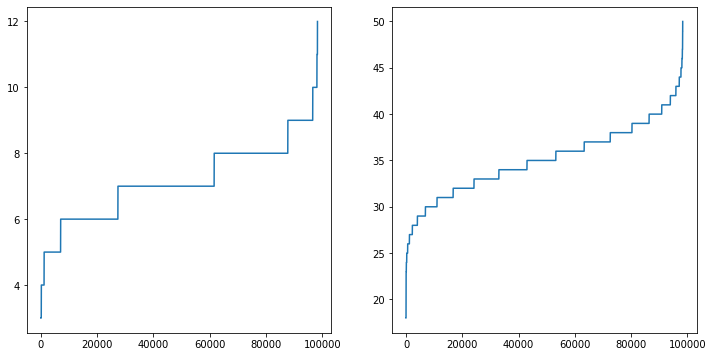

In [173]:
headlines_len = [len(s.split()) for s in clean_df['headlines']]
text_len = [len(s.split()) for s in clean_df['text']]

headlines_len.sort()
text_len.sort()

fig = plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(headlines_len)

plt.subplot(1, 2, 2)
plt.plot(text_len)

데이터 분포 폭은 줄었지만, 사실 10만개에 가까운 데이터 중 20여개는 그렇게 큰 비중이 아닌지라,  
내용을 많이 남긴것이 잘 선택한건지 모르겠긴합니다..  
그래프에서 희박해보이는 시점을 기준으로 조금 더 쳐내고, 변화를 관찰하겠습니다

In [139]:
headlines_min_len = 4    
headlines_max_len = 10
text_min_len = 26
text_max_len = 42

dataset = clean_df.copy()

dataset = dataset[dataset['text'].apply(lambda x: len(x.split()) <= text_max_len)]
dataset = dataset[dataset['text'].apply(lambda x: len(x.split()) > text_min_len)]
dataset = dataset[dataset['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
dataset = dataset[dataset['headlines'].apply(lambda x: len(x.split()) > headlines_min_len)]



In [140]:
dataset.shape

(93476, 2)

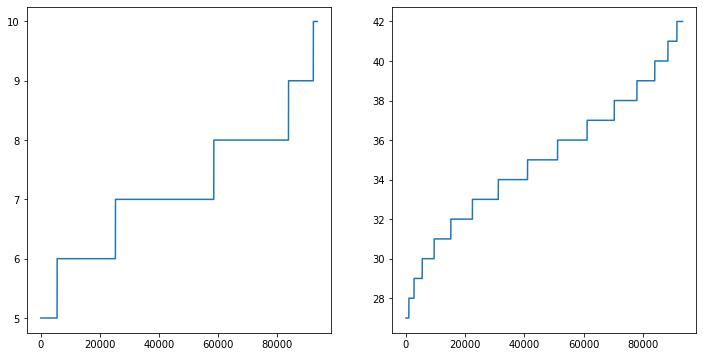

In [174]:
headlines_len = [len(s.split()) for s in dataset['headlines']]
text_len = [len(s.split()) for s in dataset['text']]

headlines_len.sort()
text_len.sort()

fig = plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(headlines_len)

plt.subplot(1, 2, 2)
plt.plot(text_len)

5000개 정도의 데이터가 사라졌군요! 5% 입니다  
하지만 그래프가 예쁘네요.. 이걸로 사용하겠습니다  

clean_df 와 dataset중 어느쪽이 바람직할지, 혹은 잘못된 전처리를 했다면 어떤식으로 했어야 했을지 피드백 꼭 부탁드립니다

#### 토큰 추가하기  
디코더에 들어갈 값에는 SOS와 EOS를 추가해줍니다  

In [143]:
dataset['decoder_input'] = dataset['headlines'].apply(lambda x : 'sostoken '+ x)
dataset['decoder_target'] = dataset['headlines'].apply(lambda x : x + ' eostoken')
dataset.sample(20)

,headlines,text,decoder_input,decoder_target
47944,uk team study ice shelf lost trillion tonne ic...,british antarctic survey led team investigate ...,sostoken uk team study ice shelf lost trillion...,uk team study ice shelf lost trillion tonne ic...
37076,bjp cell like frankenstein monster founder,founder bjp cell prodyut bora said cell become...,sostoken bjp cell like frankenstein monster fo...,bjp cell like frankenstein monster founder eos...
20274,chargesheet filed lalu family irctc hotels case,enforcement directorate filed first chargeshee...,sostoken chargesheet filed lalu family irctc h...,chargesheet filed lalu family irctc hotels cas...
5863,wheels justice moved badal sajjan kumar verdict,hailing delhi high court verdict convicting co...,sostoken wheels justice moved badal sajjan kum...,wheels justice moved badal sajjan kumar verdic...
14557,chetan bhagat accused harassing woman apologis...,author chetan bhagat today admitted screenshot...,sostoken chetan bhagat accused harassing woman...,chetan bhagat accused harassing woman apologis...
13292,yash raj films fires creative head films amid ...,yash raj films fired creative head films ashis...,sostoken yash raj films fires creative head fi...,yash raj films fires creative head films amid ...
7412,cardekho parent raise cr sequoia others report,jaipur based girnarsoft parent company online ...,sostoken cardekho parent raise cr sequoia othe...,cardekho parent raise cr sequoia others report...
89114,hp laptops found software record passwords,switzerland based cybersecurity company found ...,sostoken hp laptops found software record pass...,hp laptops found software record passwords eos...
1415,thought young something wrong shahid mira,recalling first time met mira rajput shahid ka...,sostoken thought young something wrong shahid ...,thought young something wrong shahid mira eost...
95251,govt planning deport rohingya muslims jammu,centre jammu kashmir government exploring ways...,sostoken govt planning deport rohingya muslims...,govt planning deport rohingya muslims jammu eo...


87003 번째를 보니, 잘 적용된듯이 보입니다

#### 데이터셋 분리  
데이터셋을 train / validation / test용으로 분리합니다  

In [312]:
encoder_input = np.array(dataset['text']) # 인코더의 입력
decoder_input = np.array(dataset['decoder_input']) # 디코더의 입력
decoder_target = np.array(dataset['decoder_target']) # 디코더의 레이블

In [313]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

#섞어주기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

전통적인 비율 6: 2 : 2로 데이터셋을 분리하여 train/validation/test로 사용합니다  

In [314]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 18695


In [315]:
encoder_input_train = encoder_input[:-2*(n_of_val)]
decoder_input_train = decoder_input[:-2*(n_of_val)]
decoder_target_train = decoder_target[:-2*(n_of_val)]

encoder_input_valid = encoder_input[-2*(n_of_val):-n_of_val]
decoder_input_valid = decoder_input[-2*(n_of_val):-n_of_val]
decoder_target_valid = decoder_target[-2*(n_of_val):-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_target_train))

print('검증 데이터의 개수 :', len(encoder_input_valid))
print('검증 레이블의 개수 :', len(decoder_input_valid))
print('검증 레이블의 개수 :', len(decoder_target_valid))

print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_target_test))

훈련 데이터의 개수 : 56086
훈련 레이블의 개수 : 56086
훈련 레이블의 개수 : 56086
검증 데이터의 개수 : 18695
검증 레이블의 개수 : 18695
검증 레이블의 개수 : 18695
테스트 데이터의 개수 : 18695
테스트 레이블의 개수 : 18695
테스트 레이블의 개수 : 18695


#### 단어 집합 (vocab) 생성 정수 인코딩!!  
#### 소스편

In [316]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

빈도수가 낮은 단어들은 훈련 데이터에서 제외하기 위해, 희소 단어의 갯수를 조사합니다

In [317]:
def check_rares(tokenizer, threshold):

    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [318]:
check_rares(src_tokenizer, 5)
print()
check_rares(src_tokenizer,6)
print()
check_rares(src_tokenizer,7)
print()
check_rares(src_tokenizer,8)
print()
check_rares(src_tokenizer,9)
print()
check_rares(src_tokenizer,10)

단어 집합(vocabulary)의 크기 : 59864
등장 빈도가 4번 이하인 희귀 단어의 수: 37339
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22525
단어 집합에서 희귀 단어의 비율: 62.37304556995858
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.239616965184121

단어 집합(vocabulary)의 크기 : 59864
등장 빈도가 5번 이하인 희귀 단어의 수: 39389
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20475
단어 집합에서 희귀 단어의 비율: 65.79747427502338
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.7620947229236736

단어 집합(vocabulary)의 크기 : 59864
등장 빈도가 6번 이하인 희귀 단어의 수: 41033
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 18831
단어 집합에서 희귀 단어의 비율: 68.54369905118268
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.26489673290835

단어 집합(vocabulary)의 크기 : 59864
등장 빈도가 7번 이하인 희귀 단어의 수: 42382
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17482
단어 집합에서 희귀 단어의 비율: 70.79714018441801
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.746238924745872

단어 집합(vocabulary)의 크기 : 59864
등장 빈도가 8번 이하인 희귀 단어의 수: 43478
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 16386
단어 집합에서 희귀 단어의 비율: 72.62795670185754
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.193174044732252

단어 집합(vocabulary)의 크기 : 59864
등장 빈도가 9번 이하인 희귀 단어의 수: 44407
단어 집합에서 희귀 단어를 제외시킬 경우의 단

전체적으로 드라마틱한 변화가 있는 구간은 없습니다  
threshold는 8을 사용하겠습니다  
vocab은 17000개로 제한하겠습니다  

In [319]:
threshold = 8
src_vocab = 17000

In [320]:
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [321]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_valid = src_tokenizer.texts_to_sequences(encoder_input_valid) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print("input")
print(encoder_input_train[:3])
print("valid")
print(encoder_input_valid[:3])
print("test")
print(encoder_input_test[:3])

input
[[148, 109, 529, 127, 57, 89, 435, 1598, 3599, 2753, 227, 9206, 106, 1559, 5387, 32, 1, 435, 10977, 699, 106, 1389, 2002, 97, 106, 347, 2816, 127, 700, 3599, 225, 435], [222, 1162, 621, 24, 68, 8, 9207, 14644, 4481, 1656, 2221, 14645, 1348, 1301, 578, 128, 1094, 30, 1, 8, 348, 333, 9207, 14644, 62, 58, 454, 2301, 39], [5, 16, 123, 45, 54, 314, 10613, 1258, 7022, 613, 4115, 1026, 906, 20, 197, 1801, 5, 1141, 1606, 22, 5060, 319, 614, 374, 11783, 5, 1801, 45, 96, 134, 10978, 1540, 1026, 1801]]
valid
[[2384, 26, 8340, 468, 271, 2376, 4164, 6964, 142, 209, 124, 116, 189, 2384, 8502, 1075, 11, 9164, 44, 6, 271, 9164, 35, 116, 616, 6009, 11, 5637, 2916, 260, 1417], [26, 293, 89, 7, 629, 383, 9244, 7308, 305, 629, 24, 917, 1911, 2347, 3436, 335, 833, 52, 7, 629, 3436, 335, 833, 787, 4880, 3464, 629, 12391, 866, 8673, 857, 29, 3, 305, 629], [3836, 89, 2117, 174, 577, 322, 4304, 14, 49, 160, 340, 480, 354, 85, 11707, 4724, 5091, 278, 7600, 378, 1069, 372, 49, 1148, 160, 3130, 14]]
test
[[

#### 타겟편

In [322]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [323]:
check_rares(tar_tokenizer, 5)
print()
check_rares(tar_tokenizer,6)
print()
check_rares(tar_tokenizer,7)
print()
check_rares(tar_tokenizer,8)
print()
check_rares(tar_tokenizer,9)
print()
check_rares(tar_tokenizer,10)

단어 집합(vocabulary)의 크기 : 26305
등장 빈도가 4번 이하인 희귀 단어의 수: 16683
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9622
단어 집합에서 희귀 단어의 비율: 63.4214027751378
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.286463741188044

단어 집합(vocabulary)의 크기 : 26305
등장 빈도가 5번 이하인 희귀 단어의 수: 17706
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8599
단어 집합에서 희귀 단어의 비율: 67.31039726287777
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.404557626099787

단어 집합(vocabulary)의 크기 : 26305
등장 빈도가 6번 이하인 희귀 단어의 수: 18530
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7775
단어 집합에서 희귀 단어의 비율: 70.44288158144839
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.485272419257884

단어 집합(vocabulary)의 크기 : 26305
등장 빈도가 7번 이하인 희귀 단어의 수: 19159
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7146
단어 집합에서 희귀 단어의 비율: 72.83406196540582
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.44772938411935

단어 집합(vocabulary)의 크기 : 26305
등장 빈도가 8번 이하인 희귀 단어의 수: 19677
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 6628
단어 집합에서 희귀 단어의 비율: 74.80326934042958
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 10.353571233400732

단어 집합(vocabulary)의 크기 : 26305
등장 빈도가 9번 이하인 희귀 단어의 수: 20151
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 

전체적으로 드라마틱한 변화가 있는 구간은 없습니다  
threshold는 7을 사용하겠습니다  
vocab은 7000개로 제한하겠습니다  

In [298]:
tar_vocab = 7000
threshold = 7

In [324]:
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)

decoder_input_valid = tar_tokenizer.texts_to_sequences(decoder_input_valid) 
decoder_target_valid = tar_tokenizer.texts_to_sequences(decoder_target_valid)

decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('valid')
print('valid ',decoder_input_valid[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 106, 1610, 91, 1258], [1, 1676, 1871, 2080, 3, 6156, 7], [1, 12, 519, 1049, 820, 4, 596, 8, 157, 1178], [1, 367, 2242, 6630, 133, 283, 1524, 597], [1, 727, 2182, 6157, 2735, 82, 1086]]
valid
valid  [[1, 1084, 96, 603, 292, 6466, 4276, 81, 1377], [1, 9, 694, 323, 22, 316, 312], [1, 2584, 323, 2900, 364, 651, 1935], [1, 4819, 2142, 2298, 3041, 346, 389], [1, 494, 659, 327, 146, 205, 104]]
target
decoder  [[106, 1610, 91, 1258, 2], [1676, 1871, 2080, 3, 6156, 7, 2], [12, 519, 1049, 820, 4, 596, 8, 157, 1178, 2], [367, 2242, 6630, 133, 283, 1524, 597, 2], [727, 2182, 6157, 2735, 82, 1086, 2]]


내부적으로는 값이 다르긴 한데, 발리데이션 왜 처음부터 계속 1 이나오는걸까요 몇번을 해봐도 똑같습니다 이상해요

특히 헤드라인에서, 낮은 빈도수의 단어들을 삭제하는 과정 중 내용이 없이 토큰만 남은 빈 샘플이 생겼을 가능성이 있습니다  
해당 케이스를 input / output에서 삭제하도록 합니다

In [325]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_valid = [index for index, sentence in enumerate(decoder_input_valid) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 평가 데이터의 개수 :', len(drop_valid))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_vaild = [sentence for index, sentence in enumerate(encoder_input_valid) if index not in drop_valid]
decoder_input_vaild = [sentence for index, sentence in enumerate(decoder_input_valid) if index not in drop_valid]
decoder_target_vaild = [sentence for index, sentence in enumerate(decoder_target_valid) if index not in drop_valid]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('평가 데이터의 개수 :', len(encoder_input_vaild))
print('평가 레이블의 개수 :', len(decoder_input_vaild))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 평가 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 56085
훈련 레이블의 개수 : 56085
평가 데이터의 개수 : 18695
평가 레이블의 개수 : 18695
테스트 데이터의 개수 : 18695
테스트 레이블의 개수 : 18695


실제로 제거된 데이터가 없었습니다  
모두 의미가 있었군요  

### 패딩  
숫자 0을 넣어 짧은 문장의 뒤쪽을 최대 길이까지 0으로 채워줍니다  
모든 문장이 같은 길이를 가질때까지!!  

In [326]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_valid = pad_sequences(encoder_input_valid, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_input_valid = pad_sequences(decoder_input_valid, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')

decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_target_valid = pad_sequences(decoder_target_valid, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 어텐션 매커니즘 사용하기  (추상적 요약)  
어텐션 매커니즘을 활용한 seq2seq을 설계합니다 

### 인코더 설계하기

In [327]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 디코더 설계하기

In [328]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

### 어텐션 매커니즘 구성

In [330]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 42, 128)      2176000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_11 (LSTM)                  [(None, 42, 256), (N 394240      embedding_5[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [331]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y= decoder_target_train, \
          validation_data=([encoder_input_valid, decoder_input_valid], decoder_target_valid), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
220/220 [==============================] - 25s 88ms/step - loss: 5.3774 - val_loss: 5.0746
Epoch 2/50
220/220 [==============================] - 18s 83ms/step - loss: 4.9278 - val_loss: 4.7690
Epoch 3/50
220/220 [==============================] - 18s 82ms/step - loss: 4.6185 - val_loss: 4.5283
Epoch 4/50
220/220 [==============================] - 18s 81ms/step - loss: 4.3802 - val_loss: 4.3940
Epoch 5/50
220/220 [==============================] - 18s 82ms/step - loss: 4.1873 - val_loss: 4.2996
Epoch 6/50
220/220 [==============================] - 18s 82ms/step - loss: 4.0204 - val_loss: 4.1438
Epoch 7/50
220/220 [==============================] - 18s 82ms/step - loss: 3.8695 - val_loss: 4.0384
Epoch 8/50
220/220 [==============================] - 18s 82ms/step - loss: 3.7356 - val_loss: 3.9798
Epoch 9/50
220/220 [==============================] - 18s 82ms/step - loss: 3.6165 - val_loss: 3.9252
Epoch 10/50
220/220 [==============================] - 18s 82ms/step - loss: 3.507

20 에폭 후 train이 멈췄습니다  

In [335]:
history.history

{'loss': [5.377357482910156,
  4.927772045135498,
  4.618518829345703,
  4.3802313804626465,
  4.1873369216918945,
  4.020374298095703,
  3.8694634437561035,
  3.735577344894409,
  3.616530179977417,
  3.507593870162964,
  3.4096479415893555,
  3.3179471492767334,
  3.23258113861084,
  3.1523165702819824,
  3.075193405151367,
  3.0037882328033447,
  2.9348223209381104,
  2.868922233581543,
  2.806713104248047,
  2.7484514713287354],
 'val_loss': [5.074603080749512,
  4.769033908843994,
  4.528320789337158,
  4.393971920013428,
  4.299627304077148,
  4.143764972686768,
  4.038407325744629,
  3.979778528213501,
  3.9252068996429443,
  3.8845274448394775,
  3.850630521774292,
  3.8215832710266113,
  3.791858196258545,
  3.788174867630005,
  3.7565135955810547,
  3.7542035579681396,
  3.7427754402160645,
  3.733210325241089,
  3.7375969886779785,
  3.74752140045166]}

loss밖에 기록이 남지 않았군요.. accuracy가 안찍히길래 확인해봤습니다

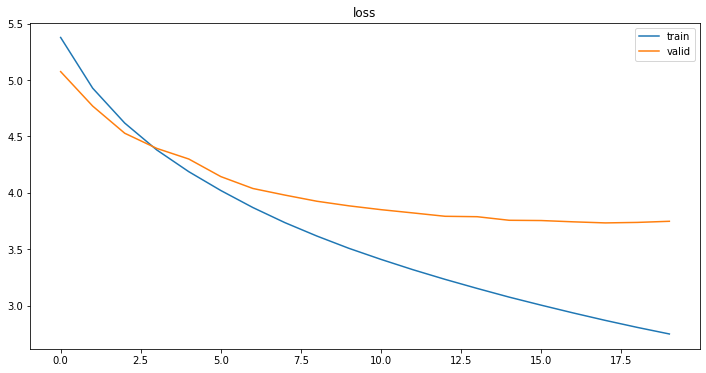

In [336]:
fig = plt.figure(figsize = (12, 6))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('loss')
plt.legend()
plt.show()

train의 loss는 점점 줄어듬을, validation loss는 어느 순간부터 줄어들지 않으며 train과 점차 격차가 커짐을 확인했습니다

## 실제 결과와 요약문 비교하기 (추상적 요약)  
인퍼런스 모델을 설계, 추상적 요약을 시도합니다  

Seq2Seq는 훈련과정과 동작과정의 방식이 달라, 모델을 별개로 진행해야합니다  
먼저 복원을 위해 단어사전을 준비합니다  

In [337]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

인퍼런스 모델을 설계합니다  
훈련과정과 다르게, 분리해서 설계합니다

In [338]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [339]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서, 단어 시퀀스를 완성하는 함수입니다

In [344]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

테스트를 위한 함수입니다

In [342]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [349]:
for i in range(10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : whatsapp top mobile app overall time spent users spent billion hours app last three months app analytics company said monday whatsapp followed wechat facebook terms time spent among gaming apps clash garnered time spent billion hours 
실제 요약 : users spent billion hours whatsapp last months 
예측 요약 :  google rolls feature maps users


원문 : youths bihar kidnapped forced marriages part custom known according bihar police cases gunpoint threats life families officials said youths kidnapped forced marriage police added 
실제 요약 : bihar men kidnapped forced marriage 
예측 요약 :  police arrest hindu hindu hindu


원문 : release date ajay devgn ranbir kapoor film director luv ranjan announced set clash box office hrithik roshan starrer krrish films scheduled christmas release krrish franchise creator rakesh roshan announced release date son hrithik birthday earlier year 
실제 요약 : ajay ranbir film clash hrithik 
예측 요약 :  ranbir release date postponed postponed reports


원문 : angelina jolie talking b

결과가 놀랍도록 안좋네요......... 그렇지만 정말 재밌습니다!!

## 추출적 요약 해보기  
패키지 summa를 사용하여 추출요약을 시행 후 비교해봅니다

In [378]:
from summa.summarizer import summarize

ㅋㅋㅋㅋ 참 쉽죠? 

In [388]:
for i in range(10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    #복원한 원문을 다시 넣어줍니다
    #encoder_input_test 선언당시의 원본데이터 지켰어야했는데ㅠㅠ
    print("예측 요약 :" , summarize(seq2text(encoder_input_test[i]), ratio=0.005))   

    print("\n")
    
    contents

원문 : whatsapp top mobile app overall time spent users spent billion hours app last three months app analytics company said monday whatsapp followed wechat facebook terms time spent among gaming apps clash garnered time spent billion hours 
실제 요약 : users spent billion hours whatsapp last months 
예측 요약 : 


원문 : youths bihar kidnapped forced marriages part custom known according bihar police cases gunpoint threats life families officials said youths kidnapped forced marriage police added 
실제 요약 : bihar men kidnapped forced marriage 
예측 요약 : 


원문 : release date ajay devgn ranbir kapoor film director luv ranjan announced set clash box office hrithik roshan starrer krrish films scheduled christmas release krrish franchise creator rakesh roshan announced release date son hrithik birthday earlier year 
실제 요약 : ajay ranbir film clash hrithik 
예측 요약 : 


원문 : angelina jolie talking brad pitt children said children good streak wonderful want perfectly behaved little people say absolutely approp

? 안나오네요?

In [389]:
contents = seq2text(encoder_input_test[0])
print("contents :" , contents)
print("type :" , type(contents))

contents : whatsapp top mobile app overall time spent users spent billion hours app last three months app analytics company said monday whatsapp followed wechat facebook terms time spent among gaming apps clash garnered time spent billion hours 
type : <class 'str'>


In [390]:
summarize(contents)

''

타입도 맞는데, 요약이 안됩니다  
뭔가 오류있는 모듈을 쓰는것일까?  
lms에서 수행했던 예문으로 해보겠습니다

In [391]:
import requests
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text
type(text)

str

In [392]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [393]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


#### 외부에서 가져온 문자열은 잘 파싱이 됩니다

In [396]:
print("문자열 직접 넣으면 ? : ", summarize('whatsapp top mobile app overall time spent users spent billion hours app last three months app analytics company said monday whatsapp followed wechat facebook terms time spent among gaming apps clash garnered time spent billion hours', ratio=0.005))

문자열 직접 넣으면 ? :  


#### 직접 복사를 해서 써봐도 안됩니다   
#### 복원된 데이터가 아닌, 원본 데이터를 사용해서 확인   

In [421]:
orig = dataset['text'].copy().values.tolist()
orig[0:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental death benefit rider life cover age years',
 'speaking sexual harassment allegations rajkumar hirani sonam kapoor said known hirani many years true metoo movement get derailed metoo movement always believe woman case need reserve judgment added 

In [422]:
#범위가 달라서 비교할 수 없습니다. 일단 출력이 되는 것을 우선으로

for i in range(10):
    print("원문 :", orig_input[i])
    print("예측 요약 :" , (summarize(orig_input[i], ratio=0.005))) 
    print("\n")
    

원문 : social media giant facebook tuesday announced feature uses facial recognition technology notify users photos tagged company said feature optional allow users protect privacy however users give consent facebook keep facial template use feature
예측 요약 : 


원문 : ministry external affairs reportedly asked government antigua barbuda confirm presence territory detain prevent movement land air sea reports said government meeting authorities antigua barbuda monday comes news choksi country
예측 요약 : 


원문 : us president donald trump friday issued veiled threat warn nations opposing joint fifa world cup bid us canada mexico would shame countries always support lobby us bid trump wrote twitter morocco rival joint bid
예측 요약 : 


원문 : evaluated answer sheets class bihar school examination board went missing week ago found scrap dealer following arrest confessed police peon ss balika high school sold peon selling answer sheets scrap dealer since
예측 요약 : 


원문 : india largest lender state bank ind

### 또 예측실패

In [405]:
type(orig_input[0])

str

분명히 str인데 예측실패..

### 문장을 여러개 붙이면 어떨까요?

In [408]:
test_txt = ''
for i in range(100):
    test_txt += orig_input[0] #0번째 문장 100번 붙여주는거 맞습니다
    test_txt += ' '

In [410]:
print("예측 요약 :" , summarize(test_txt, ratio=0.005))

예측 요약 : 


그래도 안되는군요

In [411]:
help(summarize)

Help on function summarize in module summa.summarizer:

summarize(text, ratio=0.2, words=None, language='english', split=False, scores=False, additional_stopwords=None)



아쉽지만 다음 차례에 꼭 시도해보도록 합니다 그런데 진짜 왜 안될까요? 이 부분도 피드백 꼭 부탁드리겠습니다

## 회고  

스스로 vision people 이라고 생각했는데 nlp가 재밌어져서 큰입입니다 ㅎㅎ 물론 이쪽 공부 또한 이어나갈 생각입니다  

이미지도 전처리를 이렇게 디테일하게 할 일이 있었을까? 하면 잘 모르겠습니다  
(앞으로 많이 생길 것 같긴 합니다)  
전처리의 적정선이 궁금해지는 프로젝트 진행이었습니다  

아직 어텐션 알고리즘이나, nlp에 익숙하지 않아, 공부할것이 더 있다고 느낀 노드이긴 했지만,  
첫 걱정, 첫 시작보다는 그래도 nlp에 대한 것들을 배워나가는 느낌입니다

### 프로젝트 관련

다른 그루분들께 하신 feedback 부분에, nlp는 엄청나게 많은 문장을 모아야 좋은 퍼포먼스를 낸다는 이야기를 남기신 걸 봤어서 ㅎㅎ;
문장이 적고, 학습을 충분히 한것 같지 않아 성능이 아쉽습니다  
  
https://jrc-park.tistory.com/27 3에 소개된 방법에 따르면, 추상적 요약을 점수를 매기는 기준이 있다고 합니다  
추출적 요약 알고리즘에서 정성적으로도 괜찮은 퍼포먼스를 확인할 수 있을때, 꼭 써볼 생각입니다